# Train English model

* train English model
* test on translations from Spanish dataset
* LSTM gate unit

In [1]:
import gc
import json
import os
import random
import re
from sys import getsizeof
import time
from tqdm import tqdm

import keras
from keras.activations import tanh as Tanh
from keras.layers import Activation, Add, Dense, Embedding, Masking
from keras.layers import Input, SimpleRNN, LSTM, GRU
from keras.models import Model, load_model
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils import to_categorical 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import nltk
import numpy as np
import tensorflow as tf
import string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

keras.backend.set_epsilon(1e-16)
keras.__version__
nltk.download('punkt')
nltk.download('wordnet')

np.random.seed(42)
random.seed(12345)
tf.set_random_seed(1234)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
keras.backend.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/invictus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/invictus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# DATASET PATHS
fasttext_enbeddings = "../../data/embeddings/fasttext/multi/wiki.multi.en.vec"
TRAIN_SENTENCES = "../../data/semeval/en/en-sentences-train.txt"
TRAIN_LABELS = "../../data/semeval/en/en-labels-train.txt"
VAL_SENTENCES = "../../data/semeval/en/en-sentences-test.txt"
VAL_LABELS = "../../data/semeval/en/en-labels-test.txt"
TEST_SENTENCES = "../../data/semeval/es/es-en_translated-test-sentenses.txt"
TEST_LABELS = "../../data/semeval/es/es-en_translated-test-labels.txt"

for link_ in [fasttext_enbeddings, TRAIN_SENTENCES, TRAIN_LABELS, TEST_SENTENCES, TEST_LABELS, VAL_SENTENCES, VAL_LABELS]:
    if not os.path.isfile(link_):
        print(f"`{link_}` NOT FOUND!")

In [3]:
# READ DATASET FUNCTIONS
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def preprocess_text(text):
    text = denoise_text(text)
    text = replace_contractions(text)
    return text

def split_into_words(text):
    return nltk.word_tokenize(text)

""" WORD LEVEL - NORMALIZATION """
# words = nltk.word_tokenize(sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word, comma=".")
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
#     words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

def read_labels(file_path):
    with open(file_path, "r") as labs_f:
        labels = [float(l.strip('\n')) for l in labs_f]
    return labels

def to_categorical_fractions(labels):
    # deal with fractional annotations in labels
    categories_num = to_categorical(labels).shape[1]
    results = []
    for lab in labels:
        major_label = int(lab)
        minor_label = major_label + 1
        minor_weight = lab - major_label
        major_weight = 1 - minor_weight
        cur_result = np.zeros(categories_num)
        cur_result[major_label] = major_weight
        if minor_weight > 0:
            cur_result[minor_label] = minor_weight
        results.append(cur_result)
    return np.array(results)

def read_linear_dataset(dataset_path):
    # return array of sentense pairs and vocabulary
    with open(dataset_path, "r") as ds_f:
        result = [[],[]]
        for line in ds_f:
            cur_line = line.split("\t")
            assert len(cur_line) == 2, f"error in cur_line (len {len(cur_line)}): {cur_line}"
            sent1 = cur_line[0].strip(" ")
            sent1 = preprocess_text(sent1)
            sent1 = split_into_words(sent1)
            sent1 = normalize(sent1)
            result[0].append(sent1)
            sent2 = preprocess_text(cur_line[1].strip("\n").strip(" "))
            sent2 = split_into_words(sent2)
            sent2 = normalize(sent2)
            result[1].append(sent2)
    return result

def get_embeddings(embeddings_path, words_num=None):
    # adapted to FastText embeddings
    with open(embeddings_path, "r") as emb_f:
        word2vec = {}
        for i, line in enumerate(emb_f):
            line = line.strip("\n").split(" ")
            if i == 0:
                total_word_num = int(line[0])
                words_num = words_num if total_word_num > words_num else total_word_num
                continue
            if line[0] in word2vec:
                print(line[0] + " is in vocab!. Vocab len: " + str(len(word2vec)))
            word2vec[line[0]] = np.asarray(line[1:], dtype='float32')
            if i == words_num:
                break
    return word2vec

def minimize_embeddings(data, principal_comp_fraction=0.85):
    """
    1. Prepare data for PCA
    2. PCA transformation
    3. Normalize features for training
    Note: first sampleshould be zeros
    """
    first_row = data[0]
    data = np.array(data[1:])
    data = StandardScaler().fit_transform(data)
    pca = PCA(principal_comp_fraction)
    data = pca.fit_transform(data)
    data = MaxAbsScaler().fit_transform(data)
    feats_num = data.shape[1]
    return np.vstack((first_row[:feats_num], data))

### READ DATASET

In [4]:
data_read_time = time.time()
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
voc_words_num = 200000

# read embeddings -> dict(word : vector)
print("reading embeddings...")
embeddings_index = get_embeddings(fasttext_enbeddings, words_num=voc_words_num)
# read labels
print("reading datasets...")
train_labels = read_labels(TRAIN_LABELS)
val_labels = read_labels(VAL_LABELS)
test_labels = read_labels(TEST_LABELS)
train_labels = to_categorical_fractions(train_labels)
val_labels = to_categorical_fractions(val_labels)
test_labels = to_categorical_fractions(test_labels)
print(f"train_labels - shape: {train_labels.shape}, type {type(train_labels)}")
print(f"test_labels - shape: {test_labels.shape}, type {type(test_labels)}")
print(f"val_labels - shape: {val_labels.shape}, type {type(val_labels)}")
print(f"embeddings_index - type {type(embeddings_index)} - length {len(embeddings_index)}")
print(f"train_label example - {train_labels[2]}")
print(f"test_label example - {test_labels[2]}")
print(f"val_labels example - {val_labels[2]}")

# read dataset -> list(sentence_str1, sentence_str2)
train_dataset = read_linear_dataset(TRAIN_SENTENCES)
test_dataset = read_linear_dataset(TEST_SENTENCES)
val_dataset = read_linear_dataset(VAL_SENTENCES)

print(f"train_dataset - type: {type(train_dataset)}, len: {len(train_dataset)}")
print(f"test_dataset - type: {type(test_dataset)}, len: {len(test_dataset)}")
print(f"val_dataset - type: {type(val_dataset)}, len: {len(val_dataset)}")
print(f"\ntrain_dataset - 5 first sentence pair lengths: ", end="")
print([(len(train_dataset[0][i]), len(train_dataset[1][i])) for i in range(5)])
print(f"test_dataset - 5 first sentence pair lengths: ", end="")
print([(len(test_dataset[0][i]), len(test_dataset[1][i])) for i in range(5)])
print(f"val_dataset - 5 first sentence pair lengths: ", end="")
print([(len(val_dataset[0][i]), len(val_dataset[1][i])) for i in range(5)])

print("\n- train_dataset example pair -")
print(train_dataset[0][0])
print(train_dataset[1][0])
print("- test_dataset example pair -")
print(test_dataset[0][8])
print(test_dataset[1][8])
print("- val_dataset example pair -")
print(val_dataset[0][8])
print(val_dataset[1][8])

tokenizer = Tokenizer(filters="", lower=False, split=' ')
tokenizer.fit_on_texts(list(embeddings_index.keys()))

sequences_1 = tokenizer.texts_to_sequences(train_dataset[0])
sequences_2 = tokenizer.texts_to_sequences(train_dataset[1])
test_sequences_1 = tokenizer.texts_to_sequences(test_dataset[0])
test_sequences_2 = tokenizer.texts_to_sequences(test_dataset[1])
val_sequences_1 = tokenizer.texts_to_sequences(val_dataset[0])
val_sequences_2 = tokenizer.texts_to_sequences(val_dataset[1])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(list(word_index.items())[:10])

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
val_data_1 = pad_sequences(val_sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
val_data_2 = pad_sequences(val_sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')

assert len(data_1) == len(data_2)
assert len(test_data_1) == len(test_data_2)
assert len(val_data_1) == len(val_data_1)

data = [data_1, data_2]
val_data = [val_data_1, val_data_2]
test_data = [test_data_1, test_data_2]
print(f"Shapes of train data tensors: {data[0].shape}, {data[0].shape}")
print(f"Shapes of test data tensors: {test_data[0].shape}, {test_data[0].shape}")
print(f"Shapes of validation data tensors: {val_data[0].shape}, {val_data[0].shape}")
print(f"Shape of train label tensor: {train_labels.shape}")
print(f"Shape of test label tensor: {test_labels.shape}")
print(f"Shape of val label tensor: {val_labels.shape}")

print(data[0][0])
print(data[1][0])

data_read_time = int(time.time() - data_read_time)
print(f"data read in {data_read_time} seconds")

reading embeddings...
reading datasets...
train_labels - shape: (2234, 6), type <class 'numpy.ndarray'>
test_labels - shape: (350, 6), type <class 'numpy.ndarray'>
val_labels - shape: (1959, 6), type <class 'numpy.ndarray'>
embeddings_index - type <class 'dict'> - length 200000
train_label example - [0.  0.  0.2 0.8 0.  0. ]
test_label example - [0.  0.  0.  0.2 0.8 0. ]
val_labels example - [0.  0.  0.  0.4 0.6 0. ]
train_dataset - type: <class 'list'>, len: 2
test_dataset - type: <class 'list'>, len: 2
val_dataset - type: <class 'list'>, len: 2

train_dataset - 5 first sentence pair lengths: [(29, 24), (11, 17), (17, 20), (21, 30), (19, 19)]
test_dataset - 5 first sentence pair lengths: [(37, 29), (35, 14), (7, 9), (38, 29), (23, 46)]
val_dataset - 5 first sentence pair lengths: [(15, 19), (18, 21), (25, 22), (22, 17), (17, 14)]

- train_dataset example pair -
['but', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'vivendi', 'be', 'keep', 'the', 'door', 'open', 'to', 'furthe

In [5]:
# embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)
print(embedding_matrix[:5])

(200001, 300)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0112864  -0.00206967 -0.0515041  ...  0.0435525  -0.00774608
   0.0724234 ]
 [-0.0469256  -0.00058526 -0.0750844  ...  0.0267626  -0.0513555
   0.0166127 ]
 [-0.0324474  -0.0462027  -0.00872643 ...  0.0826505  -0.0649553
   0.0175795 ]
 [ 0.0101791  -0.0148314   0.088268   ...  0.0415709   0.152274
   0.0196778 ]]


In [7]:
pca_time = time.time()
embedding_matrix_pca = minimize_embeddings(embedding_matrix,
                                           principal_comp_fraction=50)
pca_time = int(time.time() - pca_time)

print(embedding_matrix_pca.shape)
print(f"pca done in {pca_time} seconds")

(200001, 50)
pca done in 9 seconds


In [8]:
embedding_matrix = embedding_matrix_pca
EMBEDDING_DIM = embedding_matrix.shape[1]
del embedding_matrix_pca
print(embedding_matrix.shape)

(200001, 50)


## Model

In [9]:
# Measure
def pearson_r(y_true, y_pred):
    # https://github.com/WenYanger/Keras_Metrics/blob/master/PearsonCorr.py
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

# Model
def one_layer_simple_rnn_model(rnn_gate):

    embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH, trainable=False, name="embedding_layer")
    masking_layer = Masking(mask_value=0, name="masking_layer")
    no_activation_dense = Dense(EMBEDDING_DIM, activation=None, name="no_activation_dense")

    x1 = Input(shape=(None,), dtype='int32', name="x1")
    masked_1 = masking_layer(x1)
    embedded_sequences_1 = embedding_layer(masked_1)
    h11 = rnn_gate(embedded_sequences_1)

    x2 = Input(shape=(None,), dtype='int32', name="x2")
    masked_2 = masking_layer(x2)
    embedded_sequences_2 = embedding_layer(masked_2)
    h21 = rnn_gate(embedded_sequences_2)
    
    S11 = no_activation_dense(h11)
    S12 = no_activation_dense(h21)
    s1 = Add(name="concat_layer")([S11, S12])
    s1 = Activation('tanh', name="output_activation")(s1)
    s2 = Dense(6, activation='softmax', name="output_layer")(s1)

    model = Model(inputs=[x1, x2], outputs=s2)
    return model



## Experiments

### Training LSTM network (LSTM has shown slightly better results than GRU)

In [10]:
# setup
BASE_DIR = "en-model/6-en-model"
if not os.path.isdir(f"{BASE_DIR}/weights"):
    os.makedirs(f"{BASE_DIR}/weights")

params = {
    "output_vector_size": 50,
    "batch_size": 128,
    "epochs_num": 250,
    "learning_rate": 0.05,
    "momentum": 0,
    "decay": 0.001,
    "regularization": 0.001
}

with open(f"{BASE_DIR}/en-model_params.json", 'w') as outfile:
    json.dump(params, outfile, indent=4)

optimizer = keras.optimizers.SGD(lr=params["learning_rate"],
                                 momentum=params["momentum"],
                                 decay=params["decay"],
                                 nesterov=False)
lstm_gate = LSTM(params["output_vector_size"], activation='tanh', use_bias=True,
                 activity_regularizer=regularizers.l2(params["regularization"]))

# loggers
ckpt_file = f"{BASE_DIR}" + "/weights/weights.epoch_{epoch:02d}.valloss_{val_loss:.2f}.valpearson_{val_pearson_r:.02f}.hdf5"
checkpoint_logger = keras.callbacks.ModelCheckpoint(
    ckpt_file, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False,
    mode='auto', period=1)
tensorboard_logger = keras.callbacks.TensorBoard(
    log_dir=f'{BASE_DIR}/logs', write_graph=True, write_images=True, update_freq='epoch')
csv_logger = keras.callbacks.CSVLogger(f'{BASE_DIR}/training-log.csv')

# create model
model = one_layer_simple_rnn_model(lstm_gate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[pearson_r])
model.summary()

# before training evaluation
print("Initial evaluation")
zero_loss, zero_measure = model.evaluate(x=data, y=train_labels, batch_size=params["batch_size"], verbose=1)
val_zero_loss, val_zero_measure = model.evaluate(x=val_data, y=val_labels, batch_size=params["batch_size"], verbose=1)
test_zero_loss, test_zero_measure = model.evaluate(x=test_data, y=test_labels, batch_size=params["batch_size"], verbose=1)

print(f"initial:\nloss: {zero_loss}, val: {val_zero_loss}, test: {test_zero_loss}",
      f"\nmeasure: {zero_measure}, val: {val_zero_measure}, test: {test_zero_measure}")
with open(f"{BASE_DIR}/zero_epoch_loss_measure.txt", "w") as out_f:
    out_f.write(f"loss\ntrain: {zero_loss}\nval: {val_zero_loss}\ntest: {test_zero_loss}")
    out_f.write(f"\n\nmeasure\ntrain: {zero_measure}\nval: {val_zero_measure}\ntest {test_zero_measure}")

    
# train
start_time = time.time()
print(f"\n- Training LSTM English model")
model_history = model.fit(data, train_labels, validation_data=(val_data, val_labels),
                          epochs=params["epochs_num"], verbose=2, batch_size=params["batch_size"],
                          callbacks=[checkpoint_logger, csv_logger])

print("max val_pearson_r - {} at {}".format(
    np.max(model_history.history['val_pearson_r']),
    np.argmax(model_history.history['val_pearson_r'])+1))
    
elapsed_time = int((time.time() - start_time) / 60)

print(f"time spent - total {elapsed_time} min")

# save json dumps of experiment
OUT_PATH = f"{BASE_DIR}/en-model_histories-for-plots.json"
with open(OUT_PATH, 'w') as outfile:
    json.dump(model_history.history, outfile, indent=4)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 (None, None)         0                                            
__________________________________________________________________________________________________
x2 (InputLayer)                 (None, None)         0                                            
__________________________________________________________________________________________________
masking_layer (Masking)         (None, None)         0           x1[0][0]                         
                                                                 x2[0][0]                         
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 100, 50)      10000050    masking_layer[0][0]              
          

Epoch 53/250
 - 4s - loss: 1.4100 - pearson_r: 0.4944 - val_loss: 1.5630 - val_pearson_r: 0.3552
Epoch 54/250
 - 4s - loss: 1.4096 - pearson_r: 0.4948 - val_loss: 1.5929 - val_pearson_r: 0.3470
Epoch 55/250
 - 4s - loss: 1.4091 - pearson_r: 0.4948 - val_loss: 1.5606 - val_pearson_r: 0.3559
Epoch 56/250
 - 4s - loss: 1.4191 - pearson_r: 0.4901 - val_loss: 1.5621 - val_pearson_r: 0.3587
Epoch 57/250
 - 4s - loss: 1.4119 - pearson_r: 0.4929 - val_loss: 1.5822 - val_pearson_r: 0.3496
Epoch 58/250
 - 4s - loss: 1.4074 - pearson_r: 0.4956 - val_loss: 1.5725 - val_pearson_r: 0.3531
Epoch 59/250
 - 4s - loss: 1.4102 - pearson_r: 0.4936 - val_loss: 1.5695 - val_pearson_r: 0.3571
Epoch 60/250
 - 4s - loss: 1.4065 - pearson_r: 0.4974 - val_loss: 1.5651 - val_pearson_r: 0.3565
Epoch 61/250
 - 4s - loss: 1.4070 - pearson_r: 0.4963 - val_loss: 1.5675 - val_pearson_r: 0.3411
Epoch 62/250
 - 4s - loss: 1.4037 - pearson_r: 0.4972 - val_loss: 1.5651 - val_pearson_r: 0.3515
Epoch 63/250
 - 4s - loss: 1.4

 - 4s - loss: 1.3773 - pearson_r: 0.5110 - val_loss: 1.5708 - val_pearson_r: 0.3542
Epoch 138/250
 - 4s - loss: 1.3762 - pearson_r: 0.5109 - val_loss: 1.5344 - val_pearson_r: 0.3715
Epoch 139/250
 - 4s - loss: 1.3742 - pearson_r: 0.5120 - val_loss: 1.5321 - val_pearson_r: 0.3676
Epoch 140/250
 - 4s - loss: 1.3737 - pearson_r: 0.5130 - val_loss: 1.5330 - val_pearson_r: 0.3687
Epoch 141/250
 - 4s - loss: 1.3726 - pearson_r: 0.5125 - val_loss: 1.5864 - val_pearson_r: 0.3476
Epoch 142/250
 - 4s - loss: 1.3741 - pearson_r: 0.5118 - val_loss: 1.5629 - val_pearson_r: 0.3594
Epoch 143/250
 - 4s - loss: 1.3746 - pearson_r: 0.5116 - val_loss: 1.5471 - val_pearson_r: 0.3631
Epoch 144/250
 - 4s - loss: 1.3699 - pearson_r: 0.5146 - val_loss: 1.5408 - val_pearson_r: 0.3693
Epoch 145/250
 - 4s - loss: 1.3676 - pearson_r: 0.5166 - val_loss: 1.5478 - val_pearson_r: 0.3633
Epoch 146/250
 - 4s - loss: 1.3684 - pearson_r: 0.5154 - val_loss: 1.5307 - val_pearson_r: 0.3722
Epoch 147/250
 - 4s - loss: 1.3719

Epoch 221/250
 - 4s - loss: 1.3557 - pearson_r: 0.5228 - val_loss: 1.5440 - val_pearson_r: 0.3680
Epoch 222/250
 - 4s - loss: 1.3539 - pearson_r: 0.5255 - val_loss: 1.5502 - val_pearson_r: 0.3618
Epoch 223/250
 - 4s - loss: 1.3523 - pearson_r: 0.5257 - val_loss: 1.5253 - val_pearson_r: 0.3736
Epoch 224/250
 - 4s - loss: 1.3539 - pearson_r: 0.5249 - val_loss: 1.5392 - val_pearson_r: 0.3679
Epoch 225/250
 - 4s - loss: 1.3524 - pearson_r: 0.5249 - val_loss: 1.5295 - val_pearson_r: 0.3741
Epoch 226/250
 - 4s - loss: 1.3535 - pearson_r: 0.5250 - val_loss: 1.5526 - val_pearson_r: 0.3644
Epoch 227/250
 - 4s - loss: 1.3560 - pearson_r: 0.5231 - val_loss: 1.5380 - val_pearson_r: 0.3666
Epoch 228/250
 - 4s - loss: 1.3535 - pearson_r: 0.5244 - val_loss: 1.5231 - val_pearson_r: 0.3775
Epoch 229/250
 - 4s - loss: 1.3521 - pearson_r: 0.5242 - val_loss: 1.5655 - val_pearson_r: 0.3571
Epoch 230/250
 - 4s - loss: 1.3524 - pearson_r: 0.5254 - val_loss: 1.5890 - val_pearson_r: 0.3380
Epoch 231/250
 - 4s 

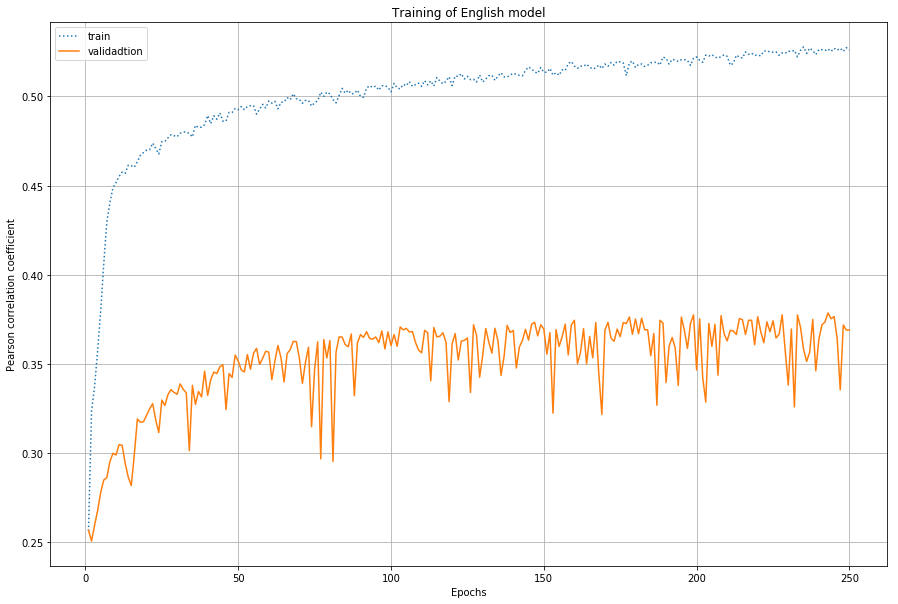

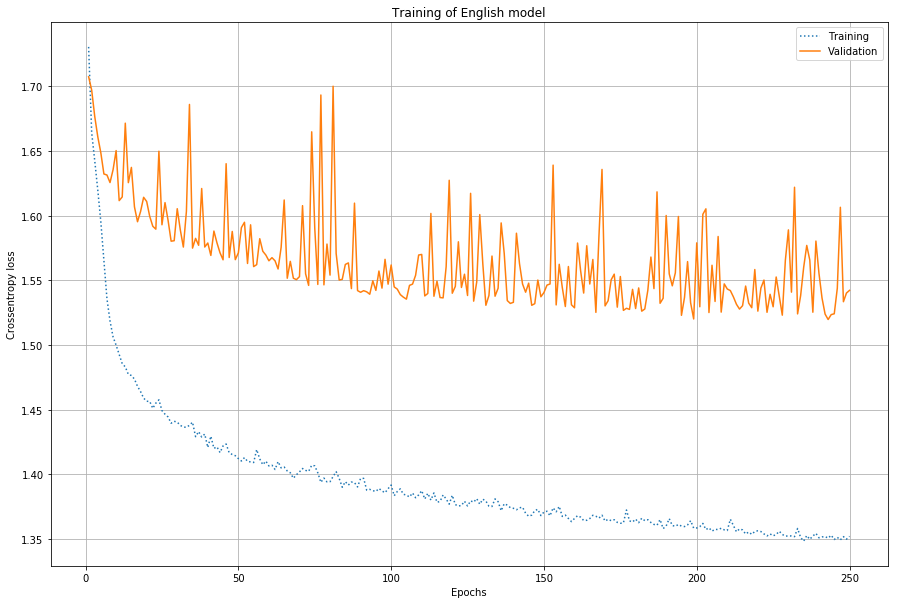

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

epochs = list(range(len(model_history.history['pearson_r'])))
acc = model_history.history['pearson_r']
val_acc = model_history.history['val_pearson_r']
plt.plot([e+1 for e in epochs], acc, linestyle=':', label=f'train')
plt.plot([e+1 for e in epochs], val_acc, label=f'validadtion')
plt.xlabel("Epochs")
plt.ylabel("Pearson correlation coefficient")
plt.title("Training of English model")
plt.legend()
plt.grid(b=True)
plt.savefig(f'{BASE_DIR}_training-output_pearson.png', bbox_inches='tight')

plt.figure()
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot([e+1 for e in epochs], loss, linestyle=':', label=f'Training')
plt.plot([e+1 for e in epochs], val_loss, label=f'Validation')
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.title('Training of English model')
plt.legend()
plt.grid(b=True)
plt.savefig(f'{BASE_DIR}_training-output_loss.png', bbox_inches='tight')
plt.show()


### Test the best model

In [13]:
# path to weights file
best_model_path = f"{BASE_DIR}/weights/weights.epoch_243.valloss_1.52.valpearson_0.38.hdf5"
best_model = load_model(best_model_path, custom_objects={'pearson_r': pearson_r})
best_model.evaluate(x=val_data, y=val_labels, batch_size=5, verbose=1)

1959/1959 [==============================] - 20s 10ms/step


[1.4975614268722555, 0.37852317108173683]

In [14]:
best_model = load_model(best_model_path, custom_objects={'pearson_r': pearson_r})
best_model.evaluate(x=test_data, y=test_labels, batch_size=5, verbose=1)

350/350 [==============================] - 4s 10ms/step


[2.69078163760049, 0.011586436183175204]